

```
# Este projeto visa construir um modelo de detecção de sentimento usando SVM (Support Vector Machine) e vetorização TF-IDF (Term Frequency-Inverse Document Frequency).
```





```
# 1 . Baixar o dataset e organizar dentro de um Dataframe Pandas.
  2 . Pré-processar o texto, removendo stopwords, convertendo para minúsculas e realizando a lemmatização.
  3 . Vetorizar o texto usando TF-IDF.
  4 . Treinar um modelo de SVM para classificar os sentimentos.
  5 . Avaliar o desempenho do modelo usando métricas de avaliação.
  6 . Exibir uma matriz de confusão para visualizar os resultados.
  7 . Permitir testes sobre o dataset fornecido pela professora.
```



In [97]:
# Instalações
!pip install nltk
!python -m spacy download pt

⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [98]:
# Imports
# Drive
from google.colab import drive
# pré-processamento de textos utilizando NLTK:
import pandas as pd
import re
import nltk
from nltk.stem.porter import *
# Spacy para lemmatização
import spacy

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
# Para plotar métricas
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.svm import LinearSVC

In [99]:
# Conectando ao google drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive
# Criando nosso objeto para manipulação de texto
lemmatizer = spacy.load("pt_core_news_sm")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 bitcoin_wallet_keywords.png   olist_preprocessado.csv	 review_repro_preprocessado.csv   tw_pt.csv
'Colab Notebooks'	       RePro.csv		 reviews_ptbr.csv
 monero_wallet_keywords.png    repro-main.zip		 tcc_analise_sentimento1.xlsx


In [100]:
# Lista de stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [101]:
# Como estamos interessados em analisar apenas os textos, vamos selecionar apenas as colunas 'review_text' e 'polarity':

df = pd.read_csv('/content/drive/MyDrive/RePro.csv')
review_df = df[['review_text', 'polarity']]
review_df

,review_text,polarity
0,"ESSE PRODUTO PODE ATÉ SER BOM, PORÉM, A AMERIC...","['NEGATIVO', 'POSITIVO']"
1,"Aparelho muito bom, confiável e com valor aqui...",['POSITIVO']
2,"As cores da impressão não são fiéis, O custo b...",['NEGATIVO']
3,"A história é muito boa, porém o autor ""enrolou...","['NEGATIVO', 'POSITIVO']"
4,"Entrega rápida, produto muito bom Amei. Pratic...",['POSITIVO']
...,...,...
9998,amei o produto. chegou no prazo e em perfeito ...,['POSITIVO']
9999,Ótima embalagem. Produto entregue no prazo. Re...,['POSITIVO']
10000,"ótimo produto, super recomendo .,Entrega bem r...",['POSITIVO']
10001,"Veio tudo certinho, dentro do prazo e o produt...",['POSITIVO']


In [102]:
# lista de stopwords em português

stopwords_pt = nltk.corpus.stopwords.words('portuguese')

# Podem ser importantes
stopwords_pt.remove('não')
stopwords_pt.remove('nem')


In [103]:
def limpa_texto(texto):
  '''(str) -> str
  Essa funcao recebe uma string, deixa tudo em minusculo, filtra apenas letras,
  retira stopwords, lemmatiza e retorna a string resultante.
  '''
  texto = texto.lower()

  texto = re.sub(r"[\W\d_]+", " ", texto)

  texto = [pal for pal in texto.split() if pal not in stopwords_pt]

  spc_texto = lemmatizer(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]

  return " ".join(tokens)

In [104]:
# Removendo comentários que tinham apenas números ou símbolos
review_df = review_df[review_df['review_text'] != '']

In [105]:
# Pré processando o texto de todas as reviews
review_df['review_text'] = review_df['review_text'].apply(limpa_texto)
# review_df = pd.read_csv('/content/drive/MyDrive/review_repro_preprocessado.csv')
review_df.head(5)

,review_text,polarity
0,produto poder bom porém americana não inspirar...,"['NEGATIVO', 'POSITIVO']"
1,aparelho bom confiável valor aquisitivo contar...,['POSITIVO']
2,cor impressãor não fiel custo benefício não va...,['NEGATIVO']
3,história bom porém autor enrolar pouco meio livro,"['NEGATIVO', 'POSITIVO']"
4,entregar rápido produto bom ameir praticidade,['POSITIVO']


In [106]:
# Salvando o dataset pré-processado em csv para faciliar acesso posterior

# review_df.to_csv('review_repro_preprocessado.csv', index= False, columns= ['review_text', 'polarity'])



```
# Vetorização do texto usando TF-IDF
```



In [107]:
# Carregamos a coluna de texto das reviews
texto = review_df['review_text']

In [108]:
# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vetorizando
X_tfidf = tfidf_vect.fit_transform(texto)

print(X_tfidf)

  (0, 3763)	0.1306458163344489
  (0, 3577)	0.08846112840674845
  (0, 607)	0.05464269135417837
  (0, 3619)	0.19388747146460616
  (0, 233)	0.28797261806685454
  (0, 3207)	0.1922091306231952
  (0, 2511)	0.22094399181075752
  (0, 3087)	0.24122605145632134
  (0, 1024)	0.17749876262265524
  (0, 4350)	0.1613749198801288
  (0, 3583)	0.09247439739574743
  (0, 4305)	0.11540965223797123
  (0, 1667)	0.12153308574550244
  (0, 4510)	0.1819195579118006
  (0, 4996)	0.16354776776466734
  (0, 961)	0.09271809034230175
  (0, 1615)	0.16858245012365008
  (0, 904)	0.12248943904959998
  (0, 1210)	0.15272653545621512
  (0, 1497)	0.19430567149502065
  (0, 767)	0.16069185375028985
  (0, 3743)	0.20144398360146246
  (0, 1751)	0.06879830552000553
  (0, 775)	0.1063894969931712
  (0, 3673)	0.12207494615147926
  :	:
  (10000, 1751)	0.33542414108283886
  (10000, 4211)	0.4339918776205267
  (10000, 3998)	0.47972440686991286
  (10000, 564)	0.37995553639091817
  (10000, 4475)	0.4567127493163512
  (10001, 3763)	0.1747394005



```
# Treinar um modelo de SVM para classificar os sentimentos
```



In [109]:
review_df.head(10)

,review_text,polarity
0,produto poder bom porém americana não inspirar...,"['NEGATIVO', 'POSITIVO']"
1,aparelho bom confiável valor aquisitivo contar...,['POSITIVO']
2,cor impressãor não fiel custo benefício não va...,['NEGATIVO']
3,história bom porém autor enrolar pouco meio livro,"['NEGATIVO', 'POSITIVO']"
4,entregar rápido produto bom ameir praticidade,['POSITIVO']
5,gostar bastante produto recomendar entregá ant...,['POSITIVO']
6,produto otimo so falta Carregador maquino pequeno,"['NEGATIVO', 'POSITIVO']"
7,recomendar aparelho Motorola bom,['POSITIVO']
8,proteção antir queda não bom cair frente telo,['NEGATIVO']
9,,['NEUTRO']


In [110]:
# Substituindo por numéricos para predição
review_df["polarity"] = review_df["polarity"].replace(["['NEGATIVO', 'POSITIVO']", "['POSITIVO']", "['NEGATIVO']", "['NEUTRO']"], [4, 1, 0, 2])

<ipython-input-110-2390835f6894>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  review_df["polarity"] = review_df["polarity"].replace(["['NEGATIVO', 'POSITIVO']", "['POSITIVO']", "['NEGATIVO']", "['NEUTRO']"], [4, 1, 0, 2])


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, review_df['polarity'],
                                                        test_size=0.3, random_state = 10)

In [113]:
def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
  principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

Acurácia:  0.789403532155948

F1-Score: 0.7803535627152075

Matriz de confusão:


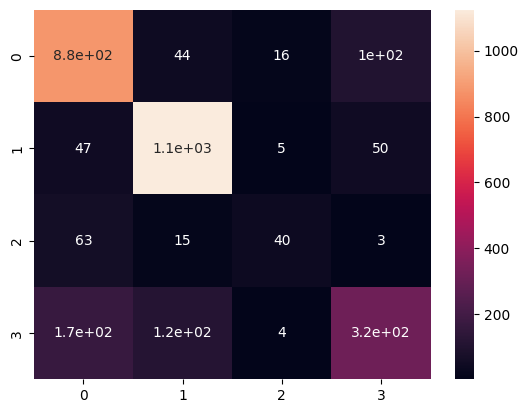

In [118]:
# O tempo de treinamento cresce de forma quadrática de acordo com a quantidade de registros

svm1 = LinearSVC()  # kernel linear é comum para problemas de texto; você pode testar outros kernels se necessário
svm1.fit(X_train.toarray(), y_train)

y_svm_pred = svm1.predict(X_test.toarray())
mostra_metricas(y_test, y_svm_pred)